## Data Exploration
Sarah Go

## Import Libraries and Dataset

In [10]:
import kagglehub
import numpy as np
import pandas as pd

from tabulate import tabulate
import matplotlib.pyplot as plt

from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/fake-news-detection")

print("Path to dataset files:", path)

# load datasets
fake=pd.read_csv(path+'/fake.csv')
true=pd.read_csv(path+'/true.csv')

Path to dataset files: C:\Users\radadmin\.cache\kagglehub\datasets\bhavikjikadara\fake-news-detection\versions\1


## Preliminary Inspection

- All/most of the true data was likely sourced from Reuters

In [19]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [20]:
true.tail()

,title,text,subject,date
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017"


In [21]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [22]:
fake.tail()

,title,text,subject,date
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016"


## Dataset Balance, Features, Missing Values, Duplicates

Summary of findings: 
- The dataset is well balanced, with 21417 true news articles, and 23481 fake news articles
- There are four features: title, text, subject and date
- There is no missing (NaN) data
- There are no articles without titles
- There are some articles without text
- There is some duplicate data: 206 duplicated true news articles, and 3 duplicated fake news articles

The articles without titles and the duplicate articles were dropped from the datasets.

True news dataset shape: (21211, 4)
Fake news dataset shape: (23478, 4)


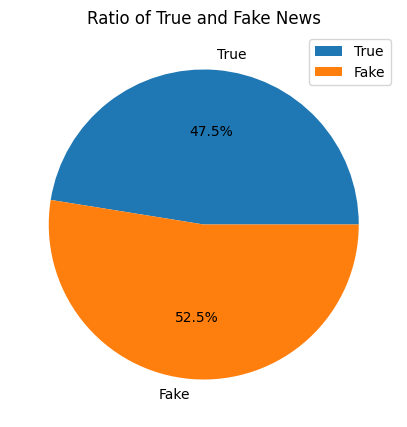

Features in 'True' Dataset:
 ['title', 'text', 'subject', 'date'] 

Features in 'Fake' Dataset:
 ['title', 'text', 'subject', 'date'] 



In [26]:
# Print shape
print("True news dataset shape:",true.shape)
print("Fake news dataset shape:",fake.shape)

# Graph pie chart displaying ratio of true and fake news
plt.figure(figsize=(5,5))
plt.title('Ratio of True and Fake News')
plt.axis('equal')
plt.pie([true.shape[0],fake.shape[0]],labels=['True','Fake'],autopct='%1.1f%%')
plt.legend()
plt.show()

# Print feature names (column names) for both datasets
print("Features in 'True' Dataset:\n", true.columns.tolist(), "\n")
print("Features in 'Fake' Dataset:\n", fake.columns.tolist(), "\n")

In [33]:
# Summary of blank and missing entries in true data
summary_true = {
    "Blank Text Entries": (true['text'].str.strip() == '').sum(),
    "Blank Title Entries": (true['title'].str.strip() == '').sum(),
    "Missing Entries (NaN)": true.isna().sum().sum(),
}

print(summary_true)

{'Blank Text Entries': 1, 'Blank Title Entries': 0, 'Missing Entries (NaN)': 0}


In [34]:
# Summary of blank and missing entries in fake data
summary_fake = {
    "Blank Text Entries": (fake['text'].str.strip() == '').sum(),
    "Blank Title Entries": (fake['title'].str.strip() == '').sum(),
    "Missing Entries (NaN)": fake.isna().sum().sum(),
}

print(summary_fake)

{'Blank Text Entries': 630, 'Blank Title Entries': 0, 'Missing Entries (NaN)': 0}


In [24]:
# Identify duplicates for both datasets
true_duplicates = true.duplicated().sum()
fake_duplicates = fake.duplicated().sum()

print("Number of Duplicates in 'True' Dataset:", true_duplicates)
print("Number of Duplicates in 'Fake' Dataset:", fake_duplicates)

Number of Duplicates in 'True' Dataset: 0
Number of Duplicates in 'Fake' Dataset: 0


In [36]:
# Drop duplicates
true = true.drop_duplicates()
fake = fake.drop_duplicates()

# Drop articles without text
indices = true[(true['text'].str.strip() == '')].index
true_cleaned = true.drop(indices)

indices = fake[(fake['text'].str.strip() == '')].index
fake_cleaned = fake.drop(indices)

# Print shape
print("True news dataset shape:",true.shape)
print("Fake news dataset shape:",fake.shape)

True news dataset shape: (21211, 4)
Fake news dataset shape: (23478, 4)


## Word Frequency Analysis

After dropping duplicate articles, the top ten most frequent words, after removing the most common stopwords, were identified for both true and fake news. Also, the top ten most divergent word frequencies between true and fake news were identified. 


Top 10 Fake Words:
['trump', 'said', 'president', 'people', 'just', 'clinton', 'obama', 'like', 'donald', 'news']

Top 10 True Words:
['said', 'trump', 'reuters', 'president', 'state', 'government', 'new', 'house', 'states', 'republican']

Top 10 Divergent Words:
['said', 'reuters', 'government', 'minister', 'china', 'united', 'state', 'washington', 'north', 'republican']


In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')

# Define stopwords
stopwords = set(stopwords.words('english'))

true_text = ' '.join(true['text'].astype(str))
fake_text = ' '.join(fake['text'].astype(str))
all_text = [true_text, fake_text]

# Initialize CountVectorizer with stopword removal
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the data
true_counts = vectorizer.fit_transform([true_text])
fake_counts = vectorizer.fit_transform([fake_text])

# Fit on all text and transform each text separately
vectorizer.fit(all_text)
true_counts = vectorizer.transform([true_text])
fake_counts = vectorizer.transform([fake_text])

# Convert to DataFrames
true_word_freq = pd.DataFrame(true_counts.toarray(), columns=vectorizer.get_feature_names_out()).T
fake_word_freq = pd.DataFrame(fake_counts.toarray(), columns=vectorizer.get_feature_names_out()).T

# Add column names for clarity
true_word_freq.columns = ['Frequency']
fake_word_freq.columns = ['Frequency']

# Get top 10 most frequent words for true and fake news
top_true = true_word_freq.sort_values(by='Frequency', ascending=False).head(10)
top_fake = fake_word_freq.sort_values(by='Frequency', ascending=False).head(10)

In [13]:
# Display top 10 most frequent words for true news
print("Top 10 Most Frequent Words in True News:")
print(tabulate(top_true.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))

Top 10 Most Frequent Words in True News:
+----+------------+-------------+
|    | Word       |   Frequency |
+====+============+=============+
|  0 | said       |       97867 |
+----+------------+-------------+
|  1 | trump      |       54098 |
+----+------------+-------------+
|  2 | reuters    |       28681 |
+----+------------+-------------+
|  3 | president  |       27879 |
+----+------------+-------------+
|  4 | state      |       20808 |
+----+------------+-------------+
|  5 | government |       18552 |
+----+------------+-------------+
|  6 | new        |       16758 |
+----+------------+-------------+
|  7 | house      |       16492 |
+----+------------+-------------+
|  8 | states     |       16422 |
+----+------------+-------------+
|  9 | republican |       16149 |
+----+------------+-------------+


In [14]:
# Display top 10 most frequent words for fake news
print("\nTop 10 Most Frequent Words in Fake News:")
print(tabulate(top_fake.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))


Top 10 Most Frequent Words in Fake News:
+----+-----------+-------------+
|    | Word      |   Frequency |
+====+===========+=============+
|  0 | trump     |       79300 |
+----+-----------+-------------+
|  1 | said      |       33762 |
+----+-----------+-------------+
|  2 | president |       27714 |
+----+-----------+-------------+
|  3 | people    |       26570 |
+----+-----------+-------------+
|  4 | just      |       20508 |
+----+-----------+-------------+
|  5 | clinton   |       19168 |
+----+-----------+-------------+
|  6 | obama     |       18797 |
+----+-----------+-------------+
|  7 | like      |       18096 |
+----+-----------+-------------+
|  8 | donald    |       17671 |
+----+-----------+-------------+
|  9 | news      |       14620 |
+----+-----------+-------------+


Compare frequencies of words between true and fake news:

In [12]:
# Combine and compare frequencies
comparison = pd.concat([true_word_freq, fake_word_freq], axis=1, keys=['True', 'Fake']).fillna(0)
comparison.columns = ['True_Frequency', 'Fake_Frequency']
comparison['Difference'] = comparison['True_Frequency'] - comparison['Fake_Frequency']

# Get top 10 most divergent words
top_divergent = comparison.sort_values(by='Difference', ascending=False).head(10)

# Display results with tabulate
print("Top 10 Most Divergent Words:")
print(tabulate(top_divergent.reset_index(), headers=['Word', 'True_Frequency', 'Fake_Frequency', 'Difference'], tablefmt='grid'))

Top 10 Most Divergent Words:
+----+------------+------------------+------------------+--------------+
|    | Word       |   True_Frequency |   Fake_Frequency |   Difference |
+====+============+==================+==================+==============+
|  0 | said       |            97867 |            33762 |        64105 |
+----+------------+------------------+------------------+--------------+
|  1 | reuters    |            28681 |              449 |        28232 |
+----+------------+------------------+------------------+--------------+
|  2 | government |            18552 |             9201 |         9351 |
+----+------------+------------------+------------------+--------------+
|  3 | minister   |             8549 |              984 |         7565 |
+----+------------+------------------+------------------+--------------+
|  4 | china      |             8719 |             1254 |         7465 |
+----+------------+------------------+------------------+--------------+
|  5 | united     |   

In [17]:
# Print list of top ten fake words
print("\nTop 10 Fake Words:")
print(top_fake.index.tolist())

# Print list of top ten true words
print("\nTop 10 True Words:")
print(top_true.index.tolist())

# Print list of top ten words
print("\nTop 10 Divergent Words:")
print(top_divergent.index.tolist())


Top 10 Fake Words:
['trump', 'said', 'president', 'people', 'just', 'clinton', 'obama', 'like', 'donald', 'news']

Top 10 True Words:
['said', 'trump', 'reuters', 'president', 'state', 'government', 'new', 'house', 'states', 'republican']

Top 10 Divergent Words:
['said', 'reuters', 'government', 'minister', 'china', 'united', 'state', 'washington', 'north', 'republican']
